In [1]:
import sys
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

sys.path.append('../3_analyze')
from containers import Dataset
from statistics import *
from prob_opt import PredictStructs

# Settings

In [2]:
data = '/scratch/PI/rondror/jbelk/method/data/'
ifp_dir = 'ifp/ifp1'
mcss_dir = 'mcss/mcss7'
glide_dir = 'docking/glide12'
num_stats_ligs = 5
num_stats_poses = 20
smooth = 0.2
struct_dict = {'D2R':'6CM4','AR':'2PNU','B1AR':'2VT4',
               'TRPV1':'3J5Q','SIGMA1':'5HK1','5HT2B':'4IB4','DTRANSP':'4M48',
               'M3':'4U15'}

features = {
    'mcss':[],
    'hbond':[2,3],
    'sb':[4],
    'pipi':[6],
    #'picat':[7,8],
    #'contact':[11]
}

# Plot Statistics

In [3]:
stats_prots = struct_dict
stats_data = Dataset(stats_prots, data, glide_dir, ifp_dir, mcss_dir)
stats_data.load({p:prot.lm.pdb for p,prot in stats_data.proteins.items()})

warning, only 2 ligands found for 5HT2B


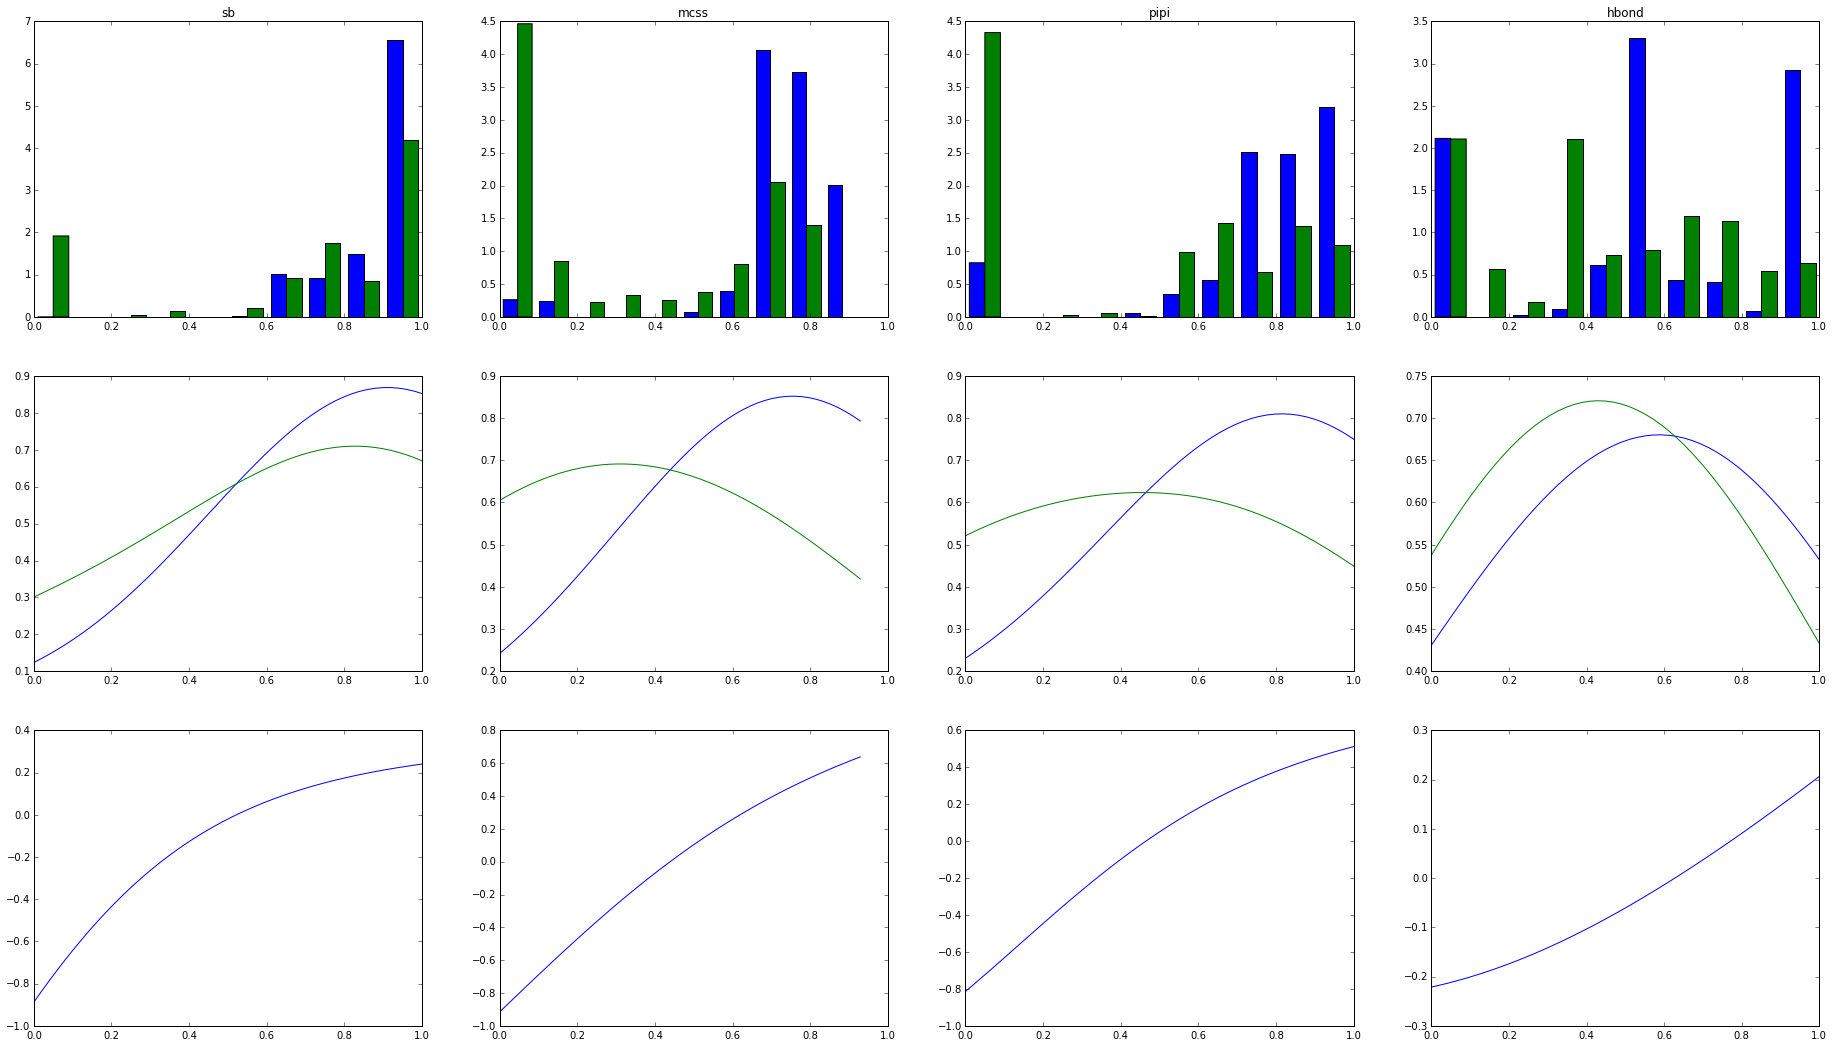

In [4]:
def  plot_statistics(evidence, points = 50):
    
    fig, ax = plt.subplots(3, len(evidence.features),
                           figsize=(len(evidence.features)*8, 18))
    
    for i, feature in enumerate(features):
        data = evidence.raw_data[feature][-1]
        if not len(data): continue
        low, high = min(data), max(data)
        X = np.linspace(low, high, points)
        native = map(lambda x: evidence.evaluate(feature, x, 1), X)
        decoy  = map(lambda x: evidence.evaluate(feature, x, 0), X)
        log_ratio = np.log(native) - np.log(decoy)
        
        ax[0, i].set_title(feature)
        ax[0, i].hist([evidence.raw_data[feature][1],
                       evidence.raw_data[feature][0]], normed = True)
        
        ax[1, i].plot(X, native)
        ax[1, i].plot(X, decoy)
        
        ax[2, i].plot(X, log_ratio)

statistics = Statistics(stats_data, stats_prots, 
                        num_stats_ligs, num_stats_poses, 
                        features, smooth)
plot_statistics(statistics.evidence)

# Benchmark on crystallographic ligands

In [4]:
def benchmark(ref, num_poses, t, smooth, optimization = 'MAX', sampling = 3):
    proteins, glides, combinds = [], [], []
    for protein in stats_data.proteins:
        docking = stats_data.proteins[protein].docking[struct_dict[protein]]
        statistics = Statistics(stats_data, {k:v for k, v in stats_prots.items() if k != protein}, 
                                num_stats_ligs, num_stats_poses, 
                                features, smooth)
        ps = PredictStructs(docking, statistics.evidence, 
                            features, num_poses, t, ref)
        l_list = sorted(stats_data.proteins[protein].lm.pdb)[:10]
        best_cluster = ps.find_best_cluster(l_list, sampling, optimization)

        us_top    = ps.get_poses(best_cluster)
        glide_top = ps.get_poses({l:0 for l in best_cluster})
        
        combinds += [np.array([po.rmsd for l,po in us_top.items()])]
        glides  += [np.array([po.rmsd for l,po in glide_top.items()])]
        proteins += [protein]
    return proteins, glides, combinds

class Table:
    def __init__(self, columns):
        self.columns = columns
    
    def __call__(self, data):
        s = ''
        for width, d in zip(self.columns, data):
            s += str(d).ljust(width, ' ')
        print s

def summarize(proteins, glides, combinds):
    table = Table([13]* 6)
    table(['Protein', 'Glide RMSD', 'ComBind RMSD', 'Glide Low', 'ComBind Low', 'Tied'])
    for protein, glide, combind in zip(proteins, glides, combinds):
        
        table([protein, round(np.mean(glide), 4), round(np.mean(combind), 4),
               np.sum(glide < combind), np.sum(glide > combind), np.sum(glide == combind)])

In [20]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       3.9448       2            4            1            
AR           2.8808       2.4305       4            3            3            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       1.7414       2            4            3            
B1AR         2.1112       2.1869       4            2            4            
SIGMA1       0.9715       0.9715       0       

In [36]:
proteins, glides, combinds = benchmark('DECOY', 100, 1, smooth, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       4.2532       3            4            0            
AR           2.8808       2.4305       4            3            3            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       2.0136       4            4            1            
B1AR         2.1112       1.2901       2            4            4            
SIGMA1       0.9715       0.9715       0       

In [21]:
proteins, glides, combinds = benchmark('LTP', 100, 1, smooth, 'MAX', 3)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       4.2532       3            4            0            
AR           2.8808       2.4305       4            3            3            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       2.0136       4            4            1            
B1AR         2.1112       1.2901       2            4            4            
SIGMA1       0.9715       0.9715       0       

In [6]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, 'ANNEAL', 10)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
8001.0
warning, only 2 ligands found for 5HT2B
8001.0
warning, only 2 ligands found for 5HT2B
28001.0
warning, only 2 ligands found for 5HT2B
40001.0
warning, only 2 ligands found for 5HT2B
8001.0
warning, only 2 ligands found for 5HT2B
36001.0
warning, only 2 ligands found for 5HT2B
40001.0
warning, only 2 ligands found for 5HT2B
8001.0
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       1.5937       1            1            0            
TRPV1        3.5045       3.5045       0            0            2            
D2R          5.8818       5.2277       4            3            0            
AR           2.8808       2.4584       5            2            3            
M3           0.8647       0.8647       0            0            2            
DTRANSP      3.0923       1.8461       2            4            3            
B1AR         2.1112       2.0245       4            5            1

In [5]:
proteins, glides, combinds = benchmark('ALL', 100, 1, smooth, 'GIBBS', 10)
summarize(proteins, glides, combinds)

warning, only 2 ligands found for SIGMA1
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
warning, only 2 ligands found for 5HT2B
Protein      Glide RMSD   ComBind RMSD Glide Low    ComBind Low  Tied         
5HT2B        1.1509       0.8047       1            1            0            
TRPV1        3.5045       4.3982       2            0            0            
D2R          5.8818       5.0196       4            3            0            
AR           2.8808       2.2648       5            3            2            
M3           0.8647       0.792        0            1            1            
DTRANSP      3.0923       2.4668       5            3            1            
B1AR         2.1112       1.5014       3            7            0            
SIGMA1       0.9715       0.8436       0       